# Segmentação de Imagens com Detectron 2

- Para implementar a Segmentação Panóptica (*panoptic segmentation*), usaremos a a biblioteca Detectron2, desenvolvida em PyTorch pelo [FAIR](https://ai.facebook.com/) (*Facebook AI Research*). Também usaremos o DETR (DEtection TRansformer) para a detecção de objetos.

- Mais sobre o Detectron2: https://ai.facebook.com/tools/detectron2/ ([repositório no Github](https://github.com/facebookresearch/Detectron2))
- Mais sobre o DETR no paper: https://arxiv.org/pdf/2005.12872.pdf 

# Importação e instalação das bibliotecas

In [85]:
import io
import cv2
import math
import matplotlib.pyplot as plt
import requests
from PIL import Image

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
from copy import deepcopy
from google.colab.patches import cv2_imshow

torch.set_grad_enabled(False);

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
#!pip install torch==1.9.0 torchvision==0.10.0
#import torch; print(torch.__version__)  #mostra versão
#!python -m pip install pip==21.3
#!pip --version #mostra versão

In [3]:
!pip3 install git+https: // github.com / cocodataset / panopticapi.git

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Looking in indexes: https://pypi.org/simple, https://pypi.ifoodcorp.com.br
  Cloning https://github.com/cocodataset/panopticapi.git to /private/var/folders/tf/pbrpvms96898w6bwjlhbg8lw0000gp/T/pip-req-build-arzty9d4
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /private/var/folders/tf/pbrpvms96898w6bwjlhbg8lw0000gp/T/pip-req-build-arzty9d4
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8260 sha256=0cb038c0423e4ac4aed3a2444a8be0497e33d123ddb4240c2dd4021082d5d4d6
  Stored in directory: /private/var/

In [8]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [12]:
!pip3 install git+https: // github.com / facebookresearch / detectron2.git

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Looking in indexes: https://pypi.org/simple, https://pypi.ifoodcorp.com.br
  Cloning https://github.com/facebookresearch/detectron2.git to /private/var/folders/tf/pbrpvms96898w6bwjlhbg8lw0000gp/T/pip-req-build-st900nu2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /private/var/folders/tf/pbrpvms96898w6bwjlhbg8lw0000gp/T/pip-req-build-st900nu2
  Resolved https://github.com/facebookresearch/detectron2.git to commit 330dd329fc43da11a4ad64148c75a891fd068ae1
  Preparing metadata (setup.py) ... done
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, p

In [10]:
!pip install --upgrade pyyaml

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Looking in indexes: https://pypi.org/simple, https://pypi.ifoodcorp.com.br
  Using cached PyYAML-6.0-cp39-cp39-macosx_10_9_x86_64.whl (197 kB)
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, ple

In [11]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Normalização

- Método padrão usado pelo Pytorch para normalização [mean-std](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html)
- mean = [0.485, 0.456, 0.406] 
- std = [0.229, 0.224, 0.225]

In [13]:
transform = T.Compose([T.Resize(800),
                       T.ToTensor(),
                       T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [14]:
transform

Compose(
    Resize(size=800, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

# Carregamento da rede neural

In [15]:
model, postprocessor = torch.hub.load('facebookresearch/detr',
                                      'detr_resnet101_panoptic',
                                      pretrained=True,
                                      return_postprocessor=True,
                                      num_classes=250)

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /Users/cesarnorena/.cache/torch/hub/main.zip
/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /Users/cesarnorena/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth" to /Users/cesarnorena/.cache/torch/hub/checkpoints/detr-r101-panoptic-40021d53.pth


  0%|          | 0.00/237M [00:00<?, ?B/s]

In [16]:
model

DETRsegm(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      

In [17]:
postprocessor

PostProcessPanoptic()

# Preparação da imagem

In [19]:
imagem = Image.open('datasets/test.jpeg')
print(imagem)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x426 at 0x134C5FD00>


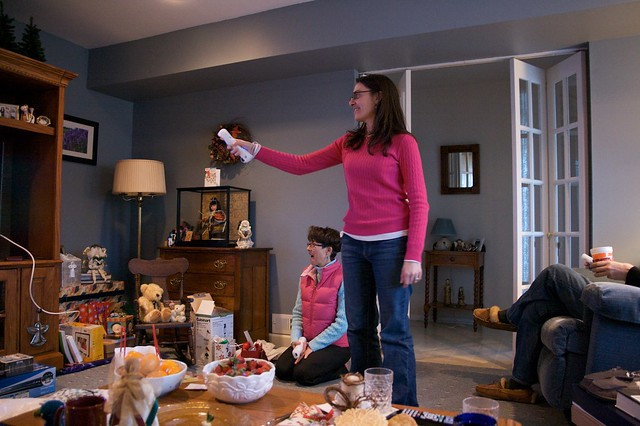

In [20]:
imagem

In [25]:
imagem.getpixel((0, 0))

(24, 31, 24)

In [26]:
img = transform(imagem).unsqueeze(0)

In [27]:
img

tensor([[[[-1.7069, -1.7240, -1.7412,  ..., -0.1314, -0.1486, -0.1657],
          [-1.7754, -1.7925, -1.8097,  ..., -0.1486, -0.1657, -0.1828],
          [-1.9124, -1.9124, -1.9295,  ..., -0.1999, -0.2171, -0.2342],
          ...,
          [-1.7754, -1.7754, -1.7754,  ..., -1.4843, -1.4672, -1.4672],
          [-1.7754, -1.7925, -1.7925,  ..., -1.4843, -1.4843, -1.4843],
          [-1.7754, -1.7925, -1.8097,  ..., -1.4843, -1.4843, -1.4843]],

         [[-1.4930, -1.5105, -1.5280,  ..., -0.1625, -0.1800, -0.1975],
          [-1.5630, -1.5805, -1.5980,  ..., -0.1975, -0.1975, -0.2150],
          [-1.7031, -1.7031, -1.7206,  ..., -0.2500, -0.2500, -0.2500],
          ...,
          [-1.7556, -1.7731, -1.7906,  ..., -1.5630, -1.5455, -1.5455],
          [-1.7206, -1.7381, -1.7556,  ..., -1.5630, -1.5630, -1.5630],
          [-1.7031, -1.7206, -1.7381,  ..., -1.5630, -1.5630, -1.5630]],

         [[-1.3861, -1.4036, -1.4210,  ..., -0.0964, -0.1138, -0.1312],
          [-1.4559, -1.4733, -

# Segmentação

In [28]:
out = model(img)

In [29]:
out

{'pred_logits': tensor([[[-13.9278,  -0.2879,  -4.5013,  ..., -13.7225, -13.8593,   7.3111],
          [-14.0619,   4.6657,  -6.8076,  ..., -14.2285, -13.7270,   8.0116],
          [-12.8998,   0.2293,  -5.0965,  ..., -12.3277, -12.7365,   7.2518],
          ...,
          [-10.2095,   2.3683,  -6.8398,  ..., -10.1404, -10.7503,   5.4253],
          [-11.4237,  -1.0295,  -7.5780,  ..., -11.6426, -11.5873,   5.6493],
          [-11.0823,  -1.0371,  -3.9687,  ..., -11.2449, -11.2927,   7.3529]]],
        grad_fn=<SelectBackward0>),
 'pred_boxes': tensor([[[0.6913, 0.5445, 0.0558, 0.0733],
          [0.9270, 0.8199, 0.1435, 0.3163],
          [0.4460, 0.5756, 0.5554, 0.4134],
          [0.2122, 0.4946, 0.4182, 0.7414],
          [0.3551, 0.9766, 0.2344, 0.0417],
          [0.5466, 0.9514, 0.2388, 0.0931],
          [0.9197, 0.6076, 0.0207, 0.0313],
          [0.1181, 0.8352, 0.0474, 0.0792],
          [0.5161, 0.5338, 0.9592, 0.8384],
          [0.5912, 0.9121, 0.0468, 0.1068],
          

In [30]:
out['pred_logits'].size()

torch.Size([1, 100, 251])

In [31]:
scores = out['pred_logits'].softmax(-1)[..., :-1].max(-1)[0]

In [32]:
scores

tensor([[0.2565, 0.2300, 0.8614, 0.4633, 0.0498, 0.5354, 0.9648, 0.2559, 0.0529,
         0.9938, 0.2977, 0.9957, 0.9919, 0.1042, 0.5033, 0.1683, 0.4126, 0.2387,
         0.1420, 0.1976, 0.7854, 0.9191, 0.2405, 0.2031, 0.0327, 0.0452, 0.2379,
         0.9916, 0.6570, 0.0239, 0.1785, 0.3795, 0.6253, 0.5450, 0.5963, 0.8930,
         0.5219, 0.1969, 0.9895, 0.8281, 0.8872, 0.9916, 0.8022, 0.9992, 0.4123,
         0.1713, 0.6783, 0.0749, 0.9731, 0.9519, 0.9711, 0.8354, 0.9959, 0.2595,
         0.9808, 0.1124, 0.4270, 0.2593, 0.0141, 0.1165, 0.6789, 0.0475, 0.0482,
         0.4962, 0.9843, 0.7945, 0.5054, 0.0954, 0.7502, 0.9416, 0.8982, 0.4614,
         0.3046, 0.2780, 0.7541, 0.6764, 0.1042, 0.9008, 0.8275, 0.0932, 0.9618,
         0.0651, 0.4762, 0.8445, 0.1228, 0.2920, 0.2992, 0.7045, 0.3883, 0.0757,
         0.0674, 0.9787, 0.0533, 0.1535, 0.3045, 0.7956, 0.9615, 0.9838, 0.5565,
         0.9204]], grad_fn=<MaxBackward0>)

# Retorno das máscaras

In [33]:
keep = scores > 0.85
print(keep)

tensor([[False, False,  True, False, False, False,  True, False, False,  True,
         False,  True,  True, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False,  True, False, False,
         False, False, False, False, False,  True, False, False,  True, False,
          True,  True, False,  True, False, False, False, False,  True,  True,
          True, False,  True, False,  True, False, False, False, False, False,
         False, False, False, False,  True, False, False, False, False,  True,
          True, False, False, False, False, False, False,  True, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False,  True,  True, False,  True]])


In [34]:
math.ceil(keep.sum().item() / 5)

6

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

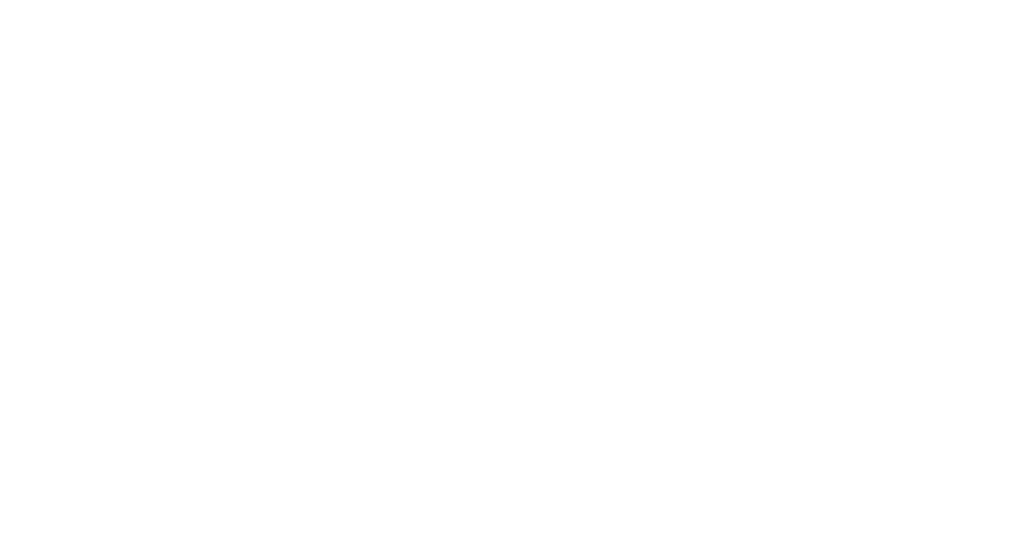

In [36]:
n_colunas = 5
fig, axs = plt.subplots(ncols=n_colunas, nrows=math.ceil(keep.sum().item() / n_colunas), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out['pred_masks'][keep]):
    ax = axs[i // n_colunas, i % n_colunas]
    ax.imshow(mask, cmap='cividis')
    ax.axis('off')

# Unificação dos segmentos

In [37]:
img.shape, img.shape[-2:], torch.as_tensor(img.shape[-2:]).unsqueeze(0)[0]

(torch.Size([1, 3, 800, 1201]), torch.Size([800, 1201]), tensor([ 800, 1201]))

In [38]:
resultado = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

In [39]:
resultado

{'png_string': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xb1\x00\x00\x03 \x08\x02\x00\x00\x00S@gk\x00\x00G\xccIDATx\x9c\xed\xdd\xebr\x1b\xc7\xb9\xa8\xe1\x91\xa9\xc8\xca\xa2\xedU\xe5\xa5\xa4j\xdf\xff\xdde+\xae\xda\xd1b,;\x91\xbd\x7f\x8c\x85\x808\x0c\xe6\xd0\x87\xaf\xbb\x9f\xa7T.\x9a\xa2\xc8!0\x00\xe6E\xf7\xf4\xbc\xf9?\x13\x00\x04\xf5\xb7\xda\x1b\x00\x00\xdd\xfb\xa6\xf6\x06\x00\x00\x00P\x8d&\x04\x00\x00\x18\x97&\x04 (\x13G\x01\xa0\x00M\x08@D\x82\x10\x00\xca\xd0\x84\x00\x84#\x08\x01\xa0\x18M\x08@,\x82\x10\x00Jz[{\x03\x00`\x9a\xa4 \x00T\xa2\t\x01\xa8L\r\x02@E\x9a\x10\x80j\xd4 \x00T\xf7\xe6i\x9a\xa6i\xfak\xe5\xcd\x00` R\x10\x00\xe20N\x08@v"\x10\x00\xc2\xd2\x84\x00d\xa1\x03\x01\xa0\t\x9a\x10\x80\x94\xa4 \x00\xb4E\x13\x02p\x94\x0e\x04\x80viB\x00\xb6Q\x80\x00\xd0\x13M\x08\xc0c:\x10\x00z\xf5\xd6U(\x00\xb8I\x07\x02\xc0\x08\x8c\x13\x020M\n\x10\x00F\xe5\x9a\xf5\x00#R\x80\x00\xc0\xcc8!\xc0(t \x00pM\x13\x02\xf4L\x07\x02\x00\xcb4!@ot \x00\xb0\x9e&\x04h\x9e\x08\x04\x00v\xfbc\x8d\x99\xc923\x00M

In [40]:
import itertools
import seaborn as sns

palette = itertools.cycle(sns.color_palette())

In [41]:
seg_panoptica = Image.open(io.BytesIO(resultado['png_string']))
seg_panoptica = numpy.array(seg_panoptica, dtype=numpy.uint8).copy()
seg_panoptica_id = rgb2id(seg_panoptica)

In [42]:
seg_panoptica_id.shape

(800, 1201)

In [44]:
seg_panoptica_id, numpy.unique(seg_panoptica_id, return_counts=True)

(array([[25, 25, 25, ...,  3,  3,  3],
        [25, 25, 25, ...,  3,  3,  3],
        [25, 25, 25, ...,  3,  3,  3],
        ...,
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14]], dtype=int32),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32),
  array([ 16339,    426,   4245, 498848,   1198,   1493,   4610,    352,
           3313,  15769,   9988,  84625,   1677,    489, 103052,  42844,
          13736,  27382,   2199,   1312,   2432,  21677,   6617,  60603,
           3330,  32244])))

(-0.5, 1200.5, 799.5, -0.5)

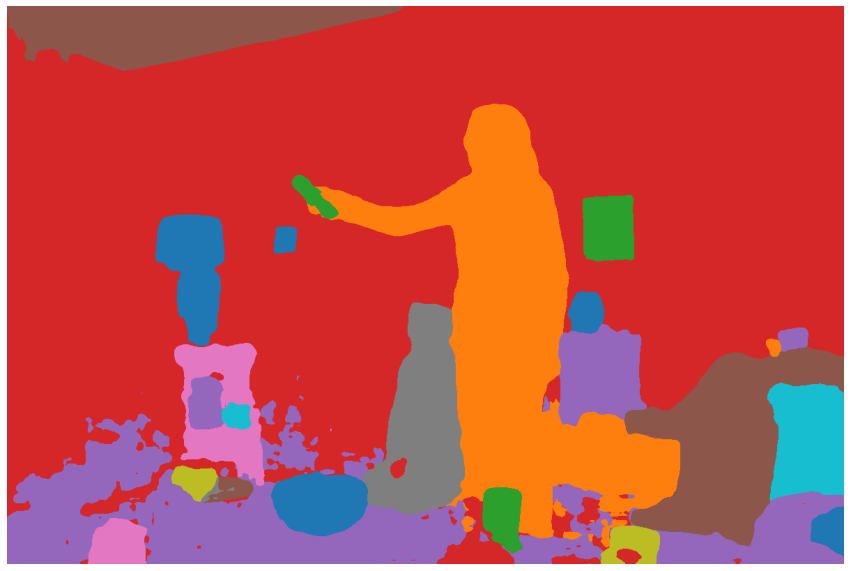

In [45]:
seg_panoptica[:, :, :] = 0
for id in range(seg_panoptica_id.max() + 1):
    seg_panoptica[seg_panoptica_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15, 15))
plt.imshow(seg_panoptica)
plt.axis('off')

# Visualização final com Detectron2

In [65]:
resultado['segments_info']

[{'id': 0, 'isthing': False, 'category_id': 130, 'area': 16339},
 {'id': 1, 'isthing': True, 'category_id': 75, 'area': 426},
 {'id': 2, 'isthing': True, 'category_id': 47, 'area': 4245},
 {'id': 3, 'isthing': False, 'category_id': 199, 'area': 498848},
 {'id': 4, 'isthing': True, 'category_id': 47, 'area': 1198},
 {'id': 5, 'isthing': True, 'category_id': 55, 'area': 1493},
 {'id': 6, 'isthing': True, 'category_id': 47, 'area': 4610},
 {'id': 7, 'isthing': True, 'category_id': 55, 'area': 352},
 {'id': 8, 'isthing': True, 'category_id': 47, 'area': 3313},
 {'id': 9, 'isthing': True, 'category_id': 63, 'area': 15769},
 {'id': 10, 'isthing': True, 'category_id': 51, 'area': 9988},
 {'id': 11, 'isthing': True, 'category_id': 1, 'area': 84625},
 {'id': 12, 'isthing': True, 'category_id': 75, 'area': 1677},
 {'id': 13, 'isthing': True, 'category_id': 75, 'area': 489},
 {'id': 14, 'isthing': False, 'category_id': 189, 'area': 103052},
 {'id': 15, 'isthing': True, 'category_id': 1, 'area': 4

In [77]:
info_segmentos = deepcopy(resultado['segments_info'])

In [78]:
seg_panoptica = Image.open(io.BytesIO(resultado['png_string']))

In [79]:
final_w, final_h = seg_panoptica.size
print(final_w, final_h)

1201 800


In [80]:
seg_panoptica = numpy.asarray(seg_panoptica, dtype=numpy.uint8)
seg_panoptica = torch.from_numpy(rgb2id(seg_panoptica))

In [81]:
meta = MetadataCatalog.get('coco_2017_val_panoptic_separated')
for i in range(len(info_segmentos)):
    c = info_segmentos[i]['category_id']
    info_segmentos[i]['category_id'] = (meta.thing_dataset_id_to_contiguous_id[c] if info_segmentos[i]['isthing'] else meta.stuff_dataset_id_to_contiguous_id[c])

In [82]:
info_segmentos

[{'id': 0, 'isthing': False, 'category_id': 13, 'area': 16339},
 {'id': 1, 'isthing': True, 'category_id': 65, 'area': 426},
 {'id': 2, 'isthing': True, 'category_id': 41, 'area': 4245},
 {'id': 3, 'isthing': False, 'category_id': 52, 'area': 498848},
 {'id': 4, 'isthing': True, 'category_id': 41, 'area': 1198},
 {'id': 5, 'isthing': True, 'category_id': 49, 'area': 1493},
 {'id': 6, 'isthing': True, 'category_id': 41, 'area': 4610},
 {'id': 7, 'isthing': True, 'category_id': 49, 'area': 352},
 {'id': 8, 'isthing': True, 'category_id': 41, 'area': 3313},
 {'id': 9, 'isthing': True, 'category_id': 57, 'area': 15769},
 {'id': 10, 'isthing': True, 'category_id': 45, 'area': 9988},
 {'id': 11, 'isthing': True, 'category_id': 0, 'area': 84625},
 {'id': 12, 'isthing': True, 'category_id': 65, 'area': 1677},
 {'id': 13, 'isthing': True, 'category_id': 65, 'area': 489},
 {'id': 14, 'isthing': False, 'category_id': 42, 'area': 103052},
 {'id': 15, 'isthing': True, 'category_id': 0, 'area': 4284

In [83]:
cores_classes = meta.stuff_colors
cores_classes

[[82, 18, 128],
 [255, 255, 128],
 [147, 211, 203],
 [150, 100, 100],
 [168, 171, 172],
 [146, 112, 198],
 [210, 170, 100],
 [92, 136, 89],
 [218, 88, 184],
 [241, 129, 0],
 [217, 17, 255],
 [124, 74, 181],
 [70, 70, 70],
 [255, 228, 255],
 [154, 208, 0],
 [193, 0, 92],
 [76, 91, 113],
 [255, 180, 195],
 [106, 154, 176],
 [230, 150, 140],
 [60, 143, 255],
 [128, 64, 128],
 [92, 82, 55],
 [254, 212, 124],
 [73, 77, 174],
 [255, 160, 98],
 [255, 255, 255],
 [104, 84, 109],
 [169, 164, 131],
 [225, 199, 255],
 [137, 54, 74],
 [135, 158, 223],
 [7, 246, 231],
 [107, 255, 200],
 [58, 41, 149],
 [183, 121, 142],
 [255, 73, 97],
 [107, 142, 35],
 [190, 153, 153],
 [146, 139, 141],
 [70, 130, 180],
 [134, 199, 156],
 [209, 226, 140],
 [96, 36, 108],
 [96, 96, 96],
 [64, 170, 64],
 [152, 251, 152],
 [208, 229, 228],
 [206, 186, 171],
 [152, 161, 64],
 [116, 112, 0],
 [0, 114, 143],
 [102, 102, 156],
 [250, 141, 255]]

In [84]:
v = Visualizer(numpy.array(imagem.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v = v.draw_panoptic_seg_predictions(seg_panoptica, info_segmentos)
resultado_final = v.get_image()
cv2_imshow(resultado_final)

NameError: name 'cv2_imshow' is not defined